In [1]:
cd ..

/home/alberto/Work/course_interpretability_deep_learning


# Multi-omics stratification on PDAC patients

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.utilities.seed import isolate_rng
import copy
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch
torch.set_float32_matmul_precision('high')

from src import settings
from utils import RemovePatientsWithZeros, RemovePatientsWithNaN, FeatureSelectionNMF, RemoveCorrelatedFeatures, RemoveFeaturesLowMAE, \
    MultiViewDataset
from model import MVAutoencoder

## Load dataset

In [3]:
methylation_data = pd.read_csv(settings.methylation_data_path, sep=";", index_col=0, decimal=",")
methylation_data.columns = methylation_data.columns.str.replace(".", "-")
methylation_data = methylation_data.T
methylation_data = methylation_data.astype(np.float32)
print("methylation_data.shape", methylation_data.shape)
methylation_data.head()

methylation_data.shape (153, 301195)


,cg00000029,cg00000236,cg00000289,cg00000292,cg00000321,cg00000622,cg00000658,cg00000714,cg00000721,cg00000734,...,ch.9.2262725R,ch.9.2285199R,ch.9.2298007R,ch.9.2473665R,ch.9.357218F,ch.9.377428R,ch.9.691424R,ch.9.837340R,ch.9.898515R,ch.9.991104F
TCGA-2J-AAB6,0.157951,0.836226,0.710511,0.560780,0.239194,0.016433,0.864604,0.087681,0.938775,0.061008,...,0.103136,0.053757,0.032478,NaN,0.064965,0.049776,0.115268,0.095954,0.084203,NaN
TCGA-2J-AAB8,0.300754,0.782242,0.574296,0.670286,0.424310,0.014747,0.885958,0.112524,0.930765,0.037198,...,0.028180,0.054483,0.022736,NaN,0.060835,0.036434,0.160082,0.059216,0.065342,0.166304
TCGA-2J-AAB9,0.257807,0.846522,0.534748,0.688073,0.295597,0.014649,0.895039,0.167297,0.940112,0.058407,...,0.059313,0.063187,0.032581,NaN,0.055342,0.069086,0.128546,0.120015,0.074940,NaN
TCGA-2J-AABA,0.239086,0.789457,0.474723,0.705372,0.530321,0.016919,0.884874,0.129581,0.910885,0.062167,...,0.122677,0.056068,0.023190,0.109351,0.056015,0.053238,0.082979,0.057172,0.045781,0.121676
TCGA-2J-AABE,0.168622,0.841684,0.591205,0.623799,0.322576,0.014408,0.898202,0.125415,0.941153,0.059365,...,0.046699,0.049177,0.032707,NaN,0.075854,0.062602,0.122072,0.082753,0.071240,NaN


In [4]:
rnaseq_data = pd.read_csv(settings.rnaseq_data_path, sep=";", index_col=0, decimal=",")
rnaseq_data = rnaseq_data.T
rnaseq_data = rnaseq_data.astype(np.float32)
print("rnaseq_data.shape", rnaseq_data.shape)
rnaseq_data.head()

rnaseq_data.shape (147, 20501)


,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
TCGA-2J-AAB6,82.549698,8.187100,0.0000,163.122803,1815.789551,8517.444336,1121.052612,1.169600,1.1696,834.502930,...,14.619900,269.005798,1053.216431,0.5848,683.625671,11696.491211,869.005798,601.754395,26.315800,0.0000
TCGA-2J-AAB8,56.930698,33.842499,0.0000,185.814301,16.921301,14413.913086,392.949493,9.400700,0.9401,801.880127,...,35.722698,356.286713,829.142212,3.7603,680.611023,5829.377441,828.202087,609.165710,85.546402,0.0000
TCGA-2J-AAB9,105.787804,21.436199,1.0718,166.709503,642.015015,24311.779297,1125.401855,50.375099,0.0000,862.808105,...,57.877800,381.564789,936.763123,1.0718,646.302307,8094.319336,1083.601318,573.419128,30.010700,0.0000
TCGA-2J-AABA,99.345497,18.788200,0.0000,99.276703,873.649597,10302.006836,633.161072,6.262700,18.7882,623.767029,...,52.606899,293.721588,1511.820923,1.2525,945.670898,4829.810547,1364.646851,793.486816,31.313601,0.6263
TCGA-2J-AABE,79.401901,3.083100,0.0000,134.564499,74.610802,11076.861328,710.343811,35.147202,0.0000,702.327698,...,56.728802,431.632507,1069.215454,0.6166,564.205322,7464.775879,832.434082,468.629608,48.096199,0.0000


In [5]:
samples = methylation_data.index.intersection(rnaseq_data.index)
methylation_data = methylation_data.loc[samples]
rnaseq_data = rnaseq_data.loc[samples]
assert methylation_data.index.equals(rnaseq_data.index)

methylation_train, methylation_val, rnaseq_train, rnaseq_val = train_test_split(methylation_data, rnaseq_data,
                                                                                train_size= 0.6, random_state= settings.RANDOM_STATE)
methylation_val, methylation_test, rnaseq_val, rnaseq_test = train_test_split(methylation_val, rnaseq_val,
                                                                              train_size= 0.5, random_state= settings.RANDOM_STATE)

In [6]:
print("methylation_data.shape", methylation_data.shape)
print("methylation_train.shape", methylation_train.shape)
print("methylation_val.shape", methylation_val.shape)
print("methylation_test.shape", methylation_test.shape)
methylation_train.head()

methylation_data.shape (147, 301195)
methylation_train.shape (88, 301195)
methylation_val.shape (29, 301195)
methylation_test.shape (30, 301195)


,cg00000029,cg00000236,cg00000289,cg00000292,cg00000321,cg00000622,cg00000658,cg00000714,cg00000721,cg00000734,...,ch.9.2262725R,ch.9.2285199R,ch.9.2298007R,ch.9.2473665R,ch.9.357218F,ch.9.377428R,ch.9.691424R,ch.9.837340R,ch.9.898515R,ch.9.991104F
TCGA-XD-AAUL,0.119118,0.837274,0.703877,0.697230,0.260051,0.016038,0.799700,0.116707,0.904165,0.061553,...,0.053820,0.070162,0.024388,0.140970,0.077960,0.055053,0.131443,0.070289,0.088595,0.180667
TCGA-FB-AAPU,0.200873,0.860951,0.550535,0.685763,0.588282,0.015656,0.902761,0.115385,0.942416,0.039498,...,0.028646,0.037191,0.023118,NaN,0.092843,0.048249,0.072598,0.063718,0.055091,0.184036
TCGA-2L-AAQJ,0.243970,0.867054,0.655630,0.616977,0.558818,0.013877,0.839384,0.109439,0.943413,0.049919,...,0.044160,0.040225,0.021784,0.136928,0.054368,0.035141,0.070832,0.046186,0.040649,0.121798
TCGA-IB-8127,0.298264,0.892158,0.732411,0.670695,0.307764,0.014719,0.821916,0.137486,0.952520,0.049755,...,0.017009,0.039114,0.017551,0.068742,0.052975,0.036810,0.079168,0.041107,0.048051,0.106006
TCGA-FB-A5VM,0.270820,0.878813,0.534142,0.619671,0.296832,0.012052,0.886043,0.136257,0.937367,0.052111,...,0.020715,0.036642,0.023079,0.370927,0.034983,0.040559,0.051178,0.055982,0.051264,0.139150


In [7]:
print("rnaseq_data.shape", rnaseq_data.shape)
print("rnaseq_train.shape", rnaseq_train.shape)
print("rnaseq_val.shape", rnaseq_val.shape)
print("rnaseq_test.shape", rnaseq_test.shape)
rnaseq_train.head()

rnaseq_data.shape (147, 20501)
rnaseq_train.shape (88, 20501)
rnaseq_val.shape (29, 20501)
rnaseq_test.shape (30, 20501)


,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
TCGA-XD-AAUL,101.975098,89.397102,0.8316,67.430397,12.889800,22677.654297,1000.415771,20.790001,3.3264,648.232788,...,49.480202,417.463593,924.740112,0.0000,709.355530,11670.686523,922.245300,505.613312,38.669399,0.0000
TCGA-FB-AAPU,29.661301,176.090393,1.5018,209.326004,2.252800,6172.876465,82.976501,84.102898,3.0037,574.452576,...,52.564301,591.348328,976.193970,0.3755,607.492981,5116.007324,1777.799561,552.300476,11.639200,0.0000
TCGA-2L-AAQJ,91.529701,17.821800,0.0000,82.044601,1.980200,15670.208008,1068.316772,214.356400,0.9901,499.505005,...,52.475201,409.405914,920.792114,1.4851,525.742615,5813.861328,842.574280,454.455414,19.306900,0.0000
TCGA-IB-8127,58.019798,49.472301,1.2951,84.390297,211.098907,13915.374023,704.785278,6.475400,0.7771,596.516174,...,42.737801,483.325806,758.401917,0.2590,587.968689,4527.099609,882.729980,600.142517,59.055901,0.2590
TCGA-FB-A5VM,140.865906,5.216500,0.0000,138.534195,810.119995,16176.593750,6401.669434,1.043300,0.0000,796.557129,...,17.214399,182.055298,1124.673950,2.0866,376.108490,10555.555664,704.225403,394.366211,18.779301,1.0433


In [8]:
rnaseq_pipeline = make_pipeline(
    RemovePatientsWithZeros(threshold= 0.2, verbose= True),
    RemoveFeaturesLowMAE(percentage_to_keep= 0.5, verbose= True),
    RemoveCorrelatedFeatures(threshold = 0.85, verbose= True),
    FunctionTransformer(lambda x: np.log2(1 + x)),
    FeatureSelectionNMF(nmf = NMF(n_components= 50, max_iter=500, random_state=settings.RANDOM_STATE), n_largest= 3, verbose= True),
    StandardScaler().set_output(transform= 'pandas'),
)
rnaseq_pipeline.fit(rnaseq_train)

RemovePatientsWithZeros keeping 17138 features
RemoveFeaturesLowMAE keeping 8569 features
RemoveCorrelatedFeatures keeping 6904 features
FeatureSelectionNMF keeping 150 features


Pipeline(steps=[('removepatientswithzeros',
                 RemovePatientsWithZeros(verbose=True)),
                ('removefeatureslowmae',
                 RemoveFeaturesLowMAE(percentage_to_keep=0.5, verbose=True)),
                ('removecorrelatedfeatures',
                 RemoveCorrelatedFeatures(threshold=0.85, verbose=True)),
                ('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x7f03ac40c3a0>)),
                ('featureselectionnmf',
                 FeatureSelectionNMF(n_largest=3,
                                     nmf=NMF(max_iter=500, n_components=50,
                                             random_state=42),
                                     verbose=True)),
                ('standardscaler', StandardScaler())])

In [9]:
transformed_rnaseq_train = rnaseq_pipeline.transform(rnaseq_train)
transformed_rnaseq_val = rnaseq_pipeline.transform(rnaseq_val)
transformed_rnaseq_test = rnaseq_pipeline.transform(rnaseq_test)
print("transformed_rnaseq_train.shape", transformed_rnaseq_train.shape)
print("transformed_rnaseq_val.shape", transformed_rnaseq_val.shape)
print("transformed_rnaseq_test.shape", transformed_rnaseq_test.shape)
transformed_rnaseq_train.head()

transformed_rnaseq_train.shape (88, 150)
transformed_rnaseq_val.shape (29, 150)
transformed_rnaseq_test.shape (30, 150)


,ACTB,ACTG1,ALPPL2,ANXA10,AQP5,AREG,C12orf36,C20orf114,CA9,CAPN9,...,TNS4,TPT1,UCA1,UGT1A10,UGT1A6,UPK1B,VIL1,VSIG1,WNT11,XIST
TCGA-XD-AAUL,1.377711,1.283202,0.873771,0.530496,0.698241,1.268197,1.112528,1.667222,-0.390824,0.885736,...,0.422731,-0.873962,1.296716,0.825211,0.978526,0.901230,1.232005,0.786613,-0.480438,-0.955095
TCGA-FB-AAPU,0.089504,3.073718,-0.299647,1.304117,-2.274756,-0.188027,0.136100,0.827431,0.151547,0.530010,...,-0.990722,0.776639,-0.637404,0.575526,-0.557144,-0.428184,1.503575,1.130367,-1.698521,1.114916
TCGA-2L-AAQJ,0.627867,1.462564,0.111647,0.923410,1.154292,0.515806,1.083329,1.311565,-0.684323,1.315569,...,1.678476,0.633906,-0.173739,0.593691,0.588944,0.493590,1.152439,1.260442,0.146435,0.860770
TCGA-IB-8127,-0.963819,-1.721784,1.068385,0.596719,-0.021600,0.923351,1.317930,-0.979773,-1.091449,0.497105,...,0.538557,-1.537145,0.528642,1.085053,0.185827,-0.764921,1.004616,-1.130930,1.595554,-0.846630
TCGA-FB-A5VM,0.621693,1.637324,0.000703,-2.783494,0.420245,1.212379,-2.287281,0.772808,-1.326160,-1.977437,...,1.145301,0.075263,-0.012212,0.273243,0.530534,1.518022,-2.981772,-2.066809,0.878491,-0.643601


In [10]:
methylation_pipeline = make_pipeline(
    RemovePatientsWithNaN(threshold = 0.2, verbose= True),
    RemoveFeaturesLowMAE(percentage_to_keep= 0.1, verbose= True),
    # RemoveCorrelatedFeatures(threshold = 0.85, verbose= True),
    SimpleImputer(strategy= "mean").set_output(transform= 'pandas'),
    FeatureSelectionNMF(nmf = NMF(n_components= 25, max_iter=1000, random_state=settings.RANDOM_STATE), n_largest= 10, verbose= True),
    StandardScaler().set_output(transform= 'pandas'),
)
methylation_pipeline.fit(methylation_train)

RemovePatientsWithNaN keeping 300944 features
RemoveFeaturesLowMAE keeping 30094 features
FeatureSelectionNMF keeping 250 features


Pipeline(steps=[('removepatientswithnan', RemovePatientsWithNaN(verbose=True)),
                ('removefeatureslowmae',
                 RemoveFeaturesLowMAE(percentage_to_keep=0.1, verbose=True)),
                ('simpleimputer', SimpleImputer()),
                ('featureselectionnmf',
                 FeatureSelectionNMF(n_largest=10,
                                     nmf=NMF(max_iter=1000, n_components=25,
                                             random_state=42),
                                     verbose=True)),
                ('standardscaler', StandardScaler())])

In [11]:
transformed_methylation_train = methylation_pipeline.transform(methylation_train)
transformed_methylation_val = methylation_pipeline.transform(methylation_val)
transformed_methylation_test = methylation_pipeline.transform(methylation_test)
print("transformed_methylation_train.shape", transformed_methylation_train.shape)
print("transformed_methylation_val.shape", transformed_methylation_val.shape)
print("transformed_methylation_test.shape", transformed_methylation_test.shape)
transformed_methylation_train.head()

transformed_methylation_train.shape (88, 250)
transformed_methylation_val.shape (29, 250)
transformed_methylation_test.shape (30, 250)


,cg00208274,cg00211215,cg00219169,cg00263677,cg00277165,cg00288598,cg00407546,cg00429618,cg00590063,cg00590260,...,cg26896255,cg26927232,cg26975184,cg27215100,cg27215768,cg27363327,cg27436995,cg27518014,cg27519330,cg27648858
TCGA-XD-AAUL,-0.688709,-1.713840,-1.278498,-0.536602,-0.848910,-0.638789,-6.816996e-01,-0.577057,0.346054,-0.543163,...,-0.366749,-0.639702,-1.992672,0.330675,-0.593425,-1.015105,-0.619884,0.706562,-1.733402,0.651739
TCGA-FB-AAPU,-1.945872,0.059582,1.164786,1.248130,1.556380,-0.187517,-9.436164e-08,0.236874,1.031779,1.022741,...,-1.167560,1.044713,1.264647,1.031804,-1.305447,2.015486,0.844234,0.543468,0.875695,-1.382316
TCGA-2L-AAQJ,-0.327782,0.910073,0.521873,0.856129,-0.348680,-0.755197,1.126507e+00,-0.097786,0.191459,0.258920,...,0.512767,-0.677124,0.742915,0.164681,-0.854530,-0.489627,0.865560,-1.458948,0.603482,0.211613
TCGA-IB-8127,0.195839,0.975029,1.451579,0.238453,-0.191673,0.125288,2.100167e+00,-0.551763,1.021747,1.545342,...,0.741228,0.052672,-0.566946,0.389151,-0.499596,1.080622,1.275766,0.506148,0.146393,-0.396684
TCGA-FB-A5VM,-0.310788,-0.347750,0.144406,0.289688,-1.079381,-0.666001,7.285536e-01,2.040396,-1.006759,-0.516435,...,-1.278436,1.507968,0.466626,-0.950118,0.749941,-0.975773,-0.172302,0.636899,1.076045,2.073017


In [12]:
Xs_train = [transformed_rnaseq_train, transformed_methylation_train]
Xs_val = [transformed_rnaseq_val, transformed_methylation_val]
Xs_test = [transformed_rnaseq_test, transformed_methylation_test]
in_channels_list = [X.shape[1] for X in Xs_train]
in_channels_list

[150, 250]

In [13]:
BATCH_SIZE = 64
training_data = MultiViewDataset(Xs= Xs_train)
validation_data = MultiViewDataset(Xs= Xs_val)
testing_data = MultiViewDataset(Xs= Xs_test)

train_dataloader = DataLoader(dataset= training_data , batch_size= BATCH_SIZE, shuffle= True, num_workers= 16)
val_dataloader = DataLoader(dataset= validation_data , batch_size= BATCH_SIZE, shuffle= False, num_workers= 16)
test_dataloader = DataLoader(dataset= testing_data , batch_size= BATCH_SIZE, shuffle= False, num_workers= 16)

In [14]:
model = MVAutoencoder(in_channels_list= in_channels_list, out_channels= 50, hidden_channels_list = [[i//5] for i in in_channels_list])
model

MVAutoencoder(
  (encoder_0): MLP(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (hidden_0): Sequential(
      (0): Linear(in_features=150, out_features=30, bias=True)
      (1): ADN(
        (N): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (output): Linear(in_features=30, out_features=50, bias=True)
  )
  (decoder_0): MLP(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (hidden_0): Sequential(
      (0): Linear(in_features=100, out_features=30, bias=True)
      (1): ADN(
        (N): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (output): Linear(in_features=30, out_features=150, bias=True)
  )
  (encoder_1): MLP(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (hidden_0): Sequential(
      (0): Linear(in_features=250, out_features=50, bias=True)
      (1): ADN(
        (N): BatchNorm1d(50, eps=

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at /home/alberto/Work/course_interpretability_deep_learning/.lr_find_5453898c-3ae4-4320-979b-1cbdbfe01453.ckpt
Restored all states from the checkpoint at /home/alberto/Work/course_interpretability_deep_learning/.lr_find_5453898c-3ae4-4320-979b-1cbdbfe01453.ckpt
/tmp/ipykernel_1613587/3385694251.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  lr_finder.plot(suggest=True).show()


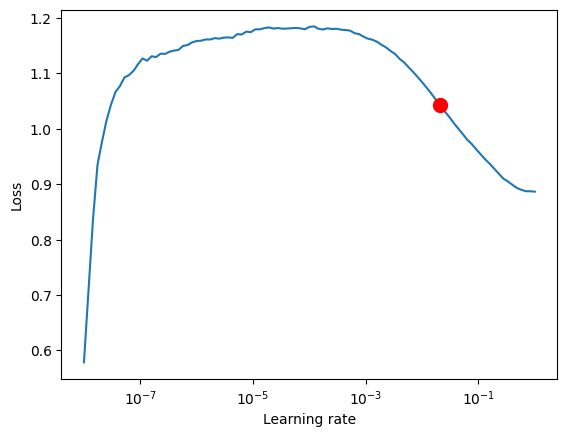

In [15]:
tuner = Tuner(pl.Trainer(logger= False, enable_checkpointing= False))
with isolate_rng():
    lr_finder = tuner.lr_find(copy.deepcopy(model), train_dataloaders= train_dataloader)
optimal_lr = lr_finder.suggestion()
model = MVAutoencoder(in_channels_list= in_channels_list, out_channels= 50, hidden_channels_list = [[i//5] for i in in_channels_list],
                      lr = optimal_lr)
lr_finder.plot(suggest=True).show()

In [16]:
trainer = pl.Trainer(logger= False, callbacks=[EarlyStopping(monitor="val_loss", patience= 7)], enable_checkpointing= False)
with isolate_rng():
    trainer.fit(model= copy.deepcopy(model), train_dataloaders= train_dataloader, val_dataloaders= val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type | Params
-----------------------------------
0 | encoder_0 | MLP  | 6.1 K 
1 | decoder_0 | MLP  | 7.7 K 
2 | encoder_1 | MLP  | 15.2 K
3 | decoder_1 | MLP  | 17.9 K
-----------------------------------
47.0 K    Trainable params
0         Non-trainable params
47.0 K    Total params
0.188     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [17]:
trainer = pl.Trainer(max_epochs= trainer.current_epoch - trainer.callbacks[0].patience, 
                     log_every_n_steps= np.ceil(len(training_data)/BATCH_SIZE).astype(int), logger= TensorBoardLogger("tensorboard", 
                                                                                                                      default_hp_metric=False))
with isolate_rng():
    trainer.fit(model= model, train_dataloaders= train_dataloader, val_dataloaders= val_dataloader)
trainer.logger.log_hyperparams({"epochs": trainer.current_epoch, **model.hparams}, 
                               {"train_loss": trainer.callback_metrics['train_loss'], "val_loss": trainer.callback_metrics['val_loss']})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type | Params
-----------------------------------
0 | encoder_0 | MLP  | 6.1 K 
1 | decoder_0 | MLP  | 7.7 K 
2 | encoder_1 | MLP  | 15.2 K
3 | decoder_1 | MLP  | 17.9 K
-----------------------------------
47.0 K    Trainable params
0         Non-trainable params
47.0 K    Total params
0.188     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=33` reached.


In [18]:
# import shutil
# shutil.rmtree("tensorboard/")
# shutil.rmtree("lightning_logs/")
# shutil.rmtree("checkpoints/")